In [11]:
# pip install dask[dataframe]

In [1]:
import pandas as pd
from sklearn import tree
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import pandas as pd
import numpy as np

#prefs
pd.set_option('max_columns', None)

#testing
import doctest
import unittest

In [2]:
policy = pd.read_csv('./2022_policy/USA_policy_2022.csv')
policy.head()

,Unnamed: 0,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C1_Notes,C2_Workplace closing,C2_Flag,C2_Notes,C3_Cancel public events,C3_Flag,C3_Notes,C4_Restrictions on gatherings,C4_Flag,C4_Notes,C5_Close public transport,C5_Flag,C5_Notes,C6_Stay at home requirements,C6_Flag,C6_Notes,C7_Restrictions on internal movement,C7_Flag,C7_Notes,C8_International travel controls,C8_Notes,E1_Income support,E1_Flag,E1_Notes,E2_Debt/contract relief,E2_Notes,E3_Fiscal measures,E3_Notes,E4_International support,E4_Notes,H1_Public information campaigns,H1_Flag,H1_Notes,H2_Testing policy,H2_Notes,H3_Contact tracing,H3_Notes,H4_Emergency investment in healthcare,H4_Notes,H5_Investment in vaccines,H5_Notes,H6_Facial Coverings,H6_Flag,H6_Notes,H7_Vaccination policy,H7_Flag,H7_Notes,H8_Protection of elderly people,H8_Flag,H8_Notes,M1_Wildcard,M1_Notes,V1_Vaccine Prioritisation (summary),V1_Notes,V2A_Vaccine Availability (summary),V2_Notes,V2B_Vaccine age eligibility/availability age floor (general population summary),V2C_Vaccine age eligibility/availability age floor (at risk summary),V2D_Medically/ clinically vulnerable (Non-elderly),V2E_Education,V2F_Frontline workers (non healthcare),V2G_Frontline workers (healthcare),V3_Vaccine Financial Support (summary),V3_Notes,V4_Mandatory Vaccination (summary),V4_Notes,ConfirmedCases,ConfirmedDeaths,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,30784,United States,USA,NaN,NaN,NAT_TOTAL,20220101,2.0,0.0,NaN,2.0,0.0,NaN,1.0,0.0,NaN,4.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,4.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,5.0,1.0,NaN,2.0,0.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,5-15 yrs,5-15 yrs,2.0,2.0,2.0,2.0,5.0,NaN,1.0,NaN,55024111.0,824703.0,53.24,53.24,63.81,63.81,52.6,52.6,60.12,60.12,0.0,0.0
1,30785,United States,USA,NaN,NaN,NAT_TOTAL,20220102,2.0,0.0,NaN,2.0,0.0,NaN,1.0,0.0,NaN,4.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,4.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,5.0,1.0,NaN,2.0,0.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,5-15 yrs,5-15 yrs,2.0,2.0,2.0,2.0,5.0,NaN,1.0,NaN,55309989.0,825081.0,53.24,53.24,63.81,63.81,52.6,52.6,60.12,60.12,0.0,0.0
2,30786,United States,USA,NaN,NaN,NAT_TOTAL,20220103,2.0,0.0,NaN,2.0,0.0,NaN,1.0,0.0,NaN,4.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,4.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,5.0,1.0,NaN,2.0,0.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,5-15 yrs,5-15 yrs,2.0,2.0,2.0,2.0,5.0,NaN,1.0,NaN,56354828.0,826921.0,53.24,53.24,63.81,63.81,52.6,52.6,60.12,60.12,0.0,0.0
3,30787,United States,USA,NaN,NaN,NAT_TOTAL,20220104,2.0,0.0,Several school districts across the country ar...,2.0,0.0,NaN,1.0,0.0,NaN,4.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,4.0,"On December 31st, the Biden administration lif...",0.0,NaN,Per the USA government guidance on employment ...,0.0,"On August 26th, the Supreme Court ruled the CD...",NaN,NaN,NaN,NaN,2.0,1.0,The CDC still maintains a robust public inform...,3.0,Testing is generally available across the US. ...,1.0,Although the highest level of contact tracing ...,NaN,NaN,NaN,NaN,3.0,0.0,NaN,5.0,1.0,Vaccines are universally available across the ...,2.0,0.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,5-15 yrs,5-15 yrs,2.0,2.0,2.0,2.0,5.0,NaN,1.0,NaN,57166940.0,829230.0,53.24,53.24,63.81,63.81,52.6,52.6,60.12,60.12,0.0,0.0
4,30788,United States,USA,NaN,NaN,NAT_TOTAL,20220105,2.0,0.0,NaN,2.0,0.0,NaN,1.0,0.0,NaN,4.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,NaN,4.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,5.0,1.0,NaN,2.0,0.0,NaN,NaN,NaN,2.0,NaN,3.0,NaN,5-15 yrs,5-15 yrs,2.0,2.0,2.0,2.0,5.0,NaN,1.0,NaN,57829451.0,

In [3]:
#policy = policy.filter(["CountryName", "Date", "ConfirmedCases", "ConfirmedDeaths", "StringencyIndex", "StringencyIndexForDisplay", "StringencyLegacyIndex", "StringencyLegacyIndexForDisplay", "GovernmentResponseIndex", "GovernmentResponseIndexForDisplay	", "ContainmentHealthIndex", "ContainmentHealthIndexForDisplay", "EconomicSupportIndex", "EconomicSupportIndexForDisplay"])
policy = policy.filter(["Date","RegionName", "ConfirmedCases", "ConfirmedDeaths", "StringencyIndex"])
policy

,Date,RegionName,ConfirmedCases,ConfirmedDeaths,StringencyIndex
0,20220101,NaN,55024111.0,824703.0,53.24
1,20220102,NaN,55309989.0,825081.0,53.24
2,20220103,NaN,56354828.0,826921.0,53.24
3,20220104,NaN,57166940.0,829230.0,53.24
4,20220105,NaN,57829451.0,831412.0,53.24
...,...,...,...,...,...
5403,20220410,Wyoming,156281.0,1796.0,NaN
5404,20220411,Wyoming,156281.0,1796.0,NaN
5405,20220412,Wyoming,156258.0,1801.0,NaN
5406,20220413,Wyoming,NaN,NaN,NaN


In [4]:
data = pd.read_csv('./us-counties-2022.csv')
data.head()

,date,county,state,fips,cases,deaths
0,2022-01-01,Autauga,Alabama,1001.0,11018,160.0
1,2022-01-01,Baldwin,Alabama,1003.0,39911,593.0
2,2022-01-01,Barbour,Alabama,1005.0,3860,81.0
3,2022-01-01,Bibb,Alabama,1007.0,4533,95.0
4,2022-01-01,Blount,Alabama,1009.0,11256,198.0


In [5]:
data = data.filter(["date", "state", "fips", "cases", "deaths"])
# data.head()
data

,date,state,fips,cases,deaths
0,2022-01-01,Alabama,1001.0,11018,160.0
1,2022-01-01,Alabama,1003.0,39911,593.0
2,2022-01-01,Alabama,1005.0,3860,81.0
3,2022-01-01,Alabama,1007.0,4533,95.0
4,2022-01-01,Alabama,1009.0,11256,198.0
...,...,...,...,...,...
426201,2022-05-11,Wyoming,56037.0,11088,126.0
426202,2022-05-11,Wyoming,56039.0,10074,16.0
426203,2022-05-11,Wyoming,56041.0,5643,39.0
426204,2022-05-11,Wyoming,56043.0,2358,44.0


In [6]:
#convert types
data["date"] = dd.to_datetime(data.date)
data
# data.head()

,date,state,fips,cases,deaths
0,2022-01-01,Alabama,1001.0,11018,160.0
1,2022-01-01,Alabama,1003.0,39911,593.0
2,2022-01-01,Alabama,1005.0,3860,81.0
3,2022-01-01,Alabama,1007.0,4533,95.0
4,2022-01-01,Alabama,1009.0,11256,198.0
...,...,...,...,...,...
426201,2022-05-11,Wyoming,56037.0,11088,126.0
426202,2022-05-11,Wyoming,56039.0,10074,16.0
426203,2022-05-11,Wyoming,56041.0,5643,39.0
426204,2022-05-11,Wyoming,56043.0,2358,44.0


In [7]:
#drop the column with Nan
df = data.dropna()
df

,date,state,fips,cases,deaths
0,2022-01-01,Alabama,1001.0,11018,160.0
1,2022-01-01,Alabama,1003.0,39911,593.0
2,2022-01-01,Alabama,1005.0,3860,81.0
3,2022-01-01,Alabama,1007.0,4533,95.0
4,2022-01-01,Alabama,1009.0,11256,198.0
...,...,...,...,...,...
426201,2022-05-11,Wyoming,56037.0,11088,126.0
426202,2022-05-11,Wyoming,56039.0,10074,16.0
426203,2022-05-11,Wyoming,56041.0,5643,39.0
426204,2022-05-11,Wyoming,56043.0,2358,44.0


In [8]:
#drop the column with Nan
df1 = policy.dropna()
df1

,Date,RegionName,ConfirmedCases,ConfirmedDeaths,StringencyIndex
104,20220101,Alaska,157169.0,978.0,45.83
105,20220102,Alaska,157169.0,978.0,45.83
106,20220103,Alaska,160089.0,979.0,45.83
107,20220104,Alaska,160089.0,979.0,45.83
108,20220105,Alaska,161678.0,979.0,45.83
...,...,...,...,...,...
5394,20220401,Wyoming,156167.0,1791.0,39.81
5395,20220402,Wyoming,156167.0,1791.0,39.81
5396,20220403,Wyoming,156167.0,1791.0,39.81
5397,20220404,Wyoming,156167.0,1791.0,39.81


In [9]:

X = df["cases"]
Y = df["state"]



/opt/homebrew/Caskroom/miniconda/base/envs/641/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


date
2022-01-01    AxesSubplot(0.125,0.125;0.775x0.755)
2022-01-02    AxesSubplot(0.125,0.125;0.775x0.755)
2022-01-03    AxesSubplot(0.125,0.125;0.775x0.755)
2022-01-04    AxesSubplot(0.125,0.125;0.775x0.755)
2022-01-05    AxesSubplot(0.125,0.125;0.775x0.755)
                              ...                 
2022-05-07    AxesSubplot(0.125,0.125;0.775x0.755)
2022-05-08    AxesSubplot(0.125,0.125;0.775x0.755)
2022-05-09    AxesSubplot(0.125,0.125;0.775x0.755)
2022-05-10    AxesSubplot(0.125,0.125;0.775x0.755)
2022-05-11    AxesSubplot(0.125,0.125;0.775x0.755)
Length: 131, dtype: object

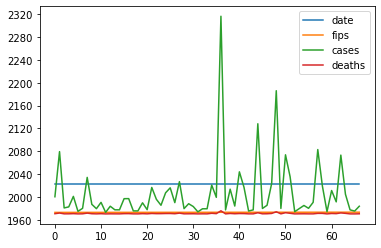

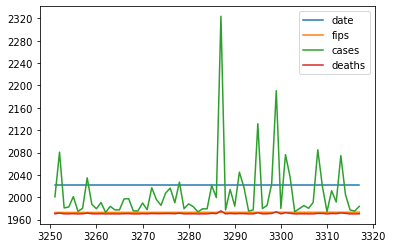

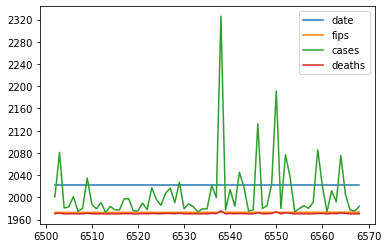

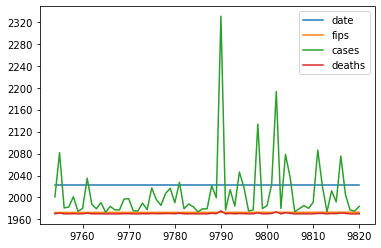

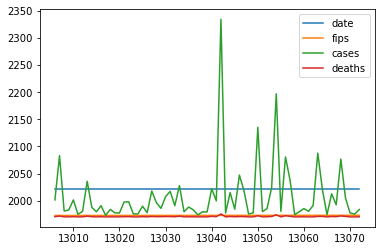

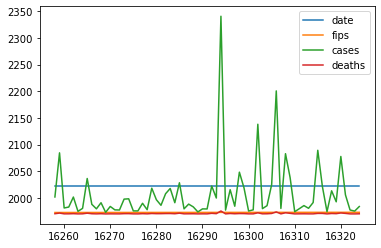

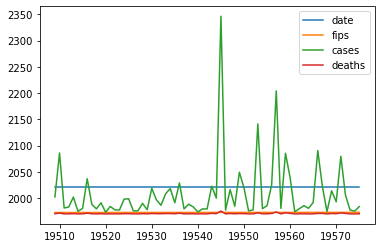

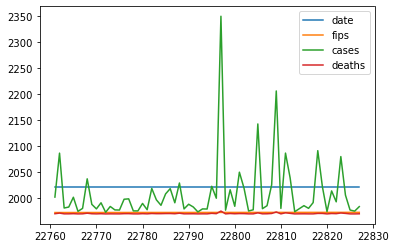

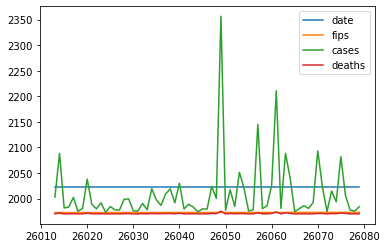

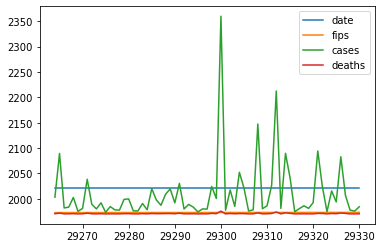

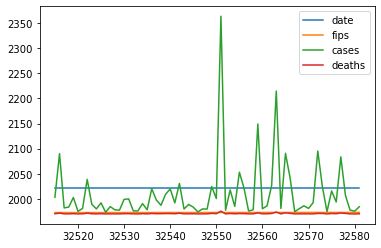

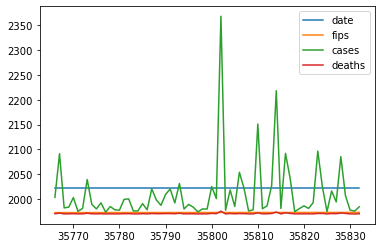

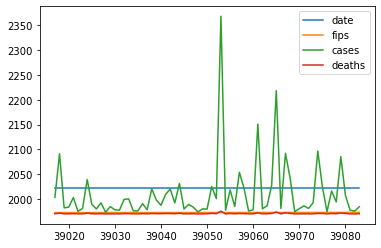

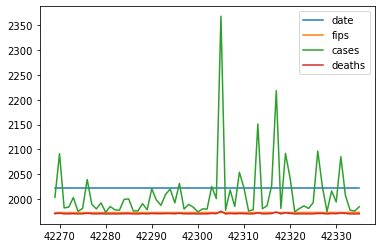

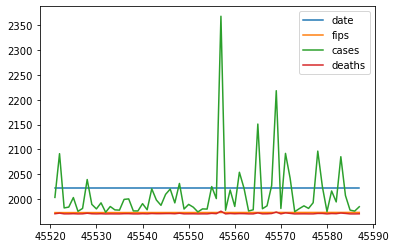

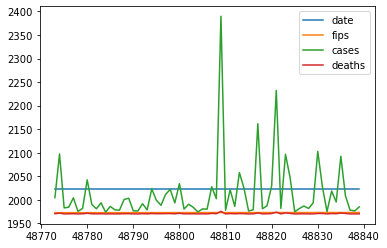

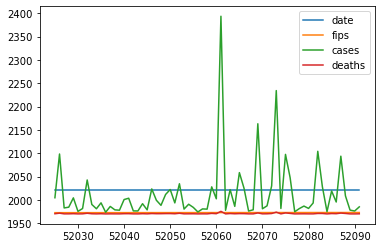

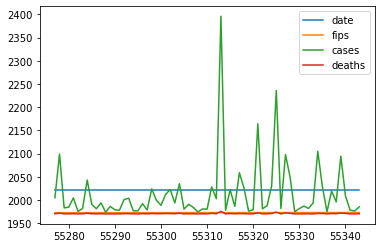

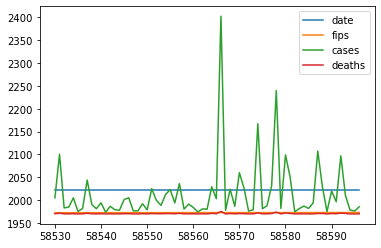

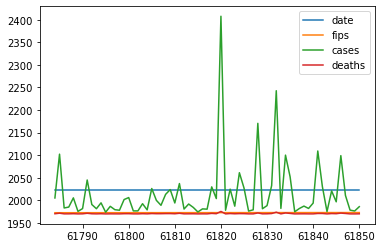

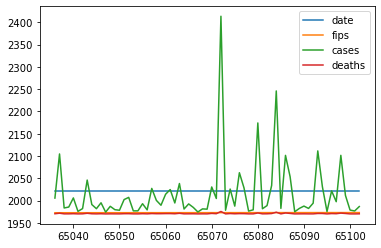

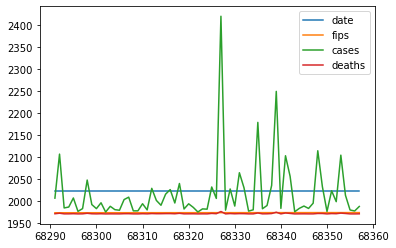

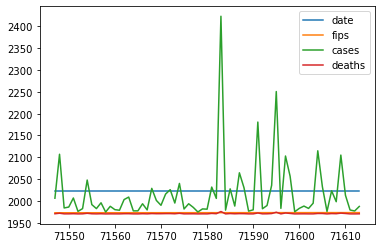

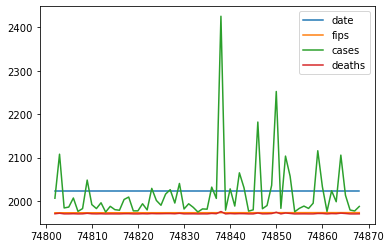

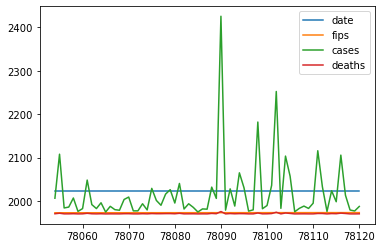

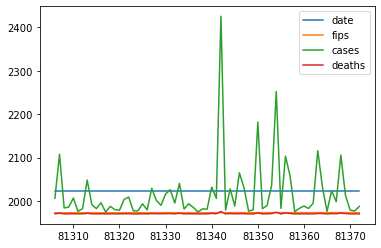

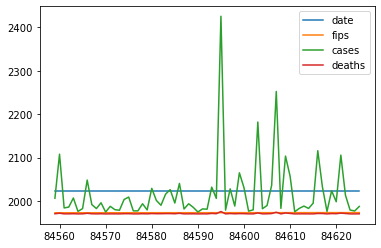

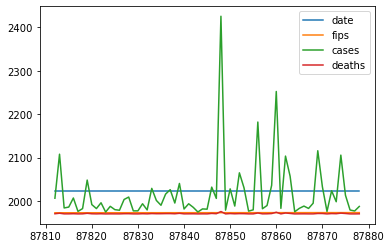

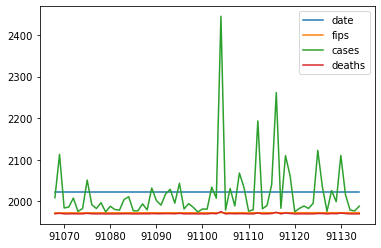

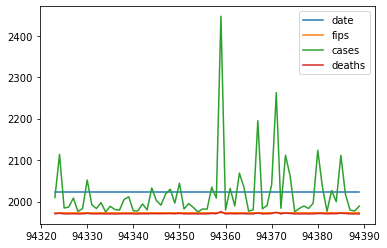

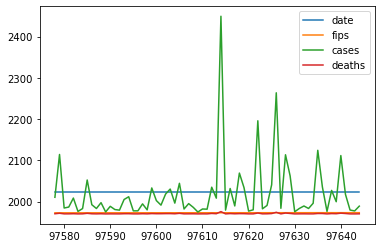

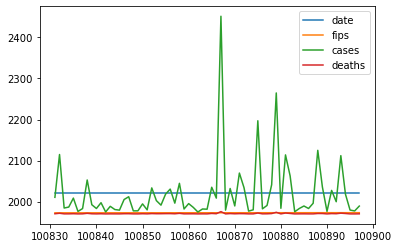

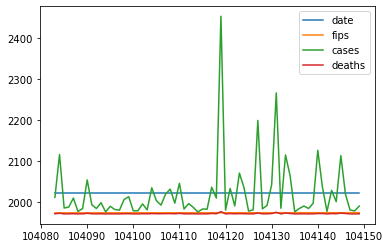

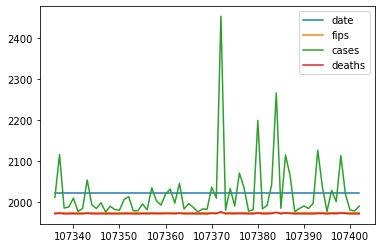

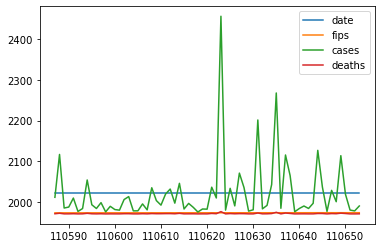

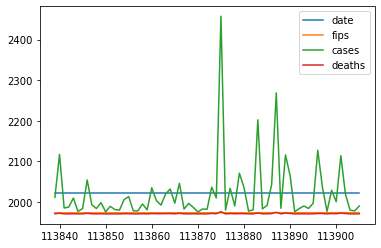

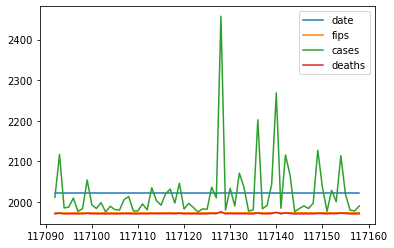

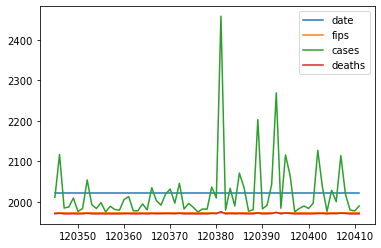

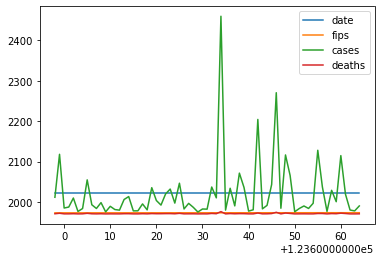

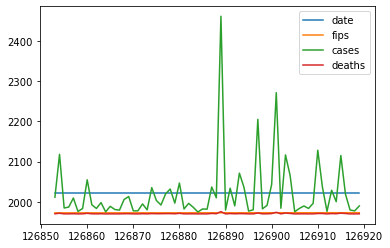

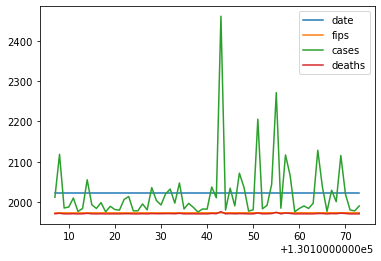

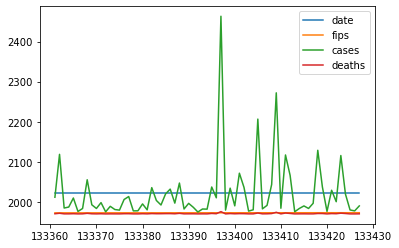

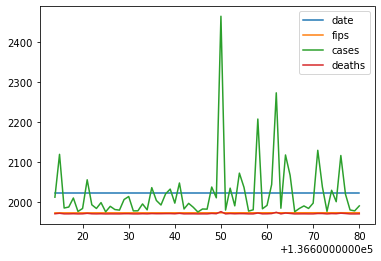

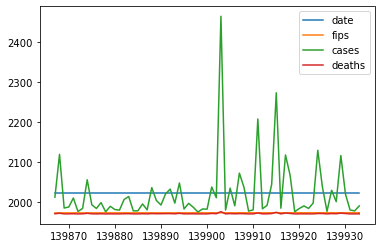

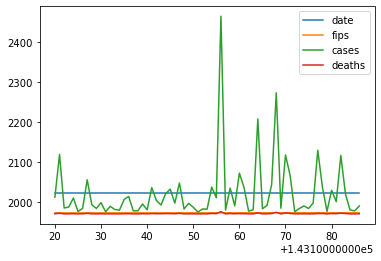

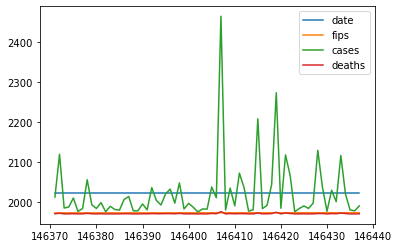

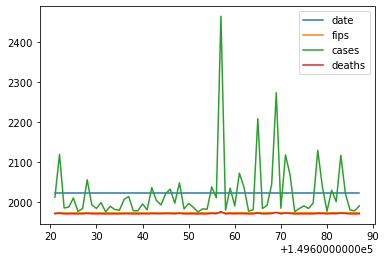

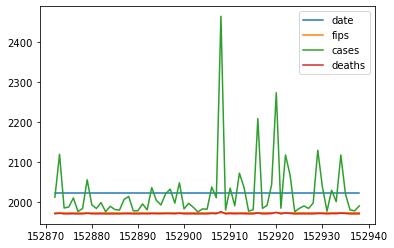

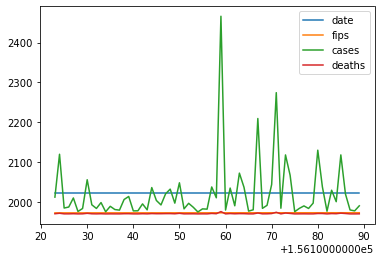

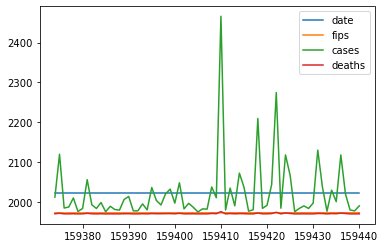

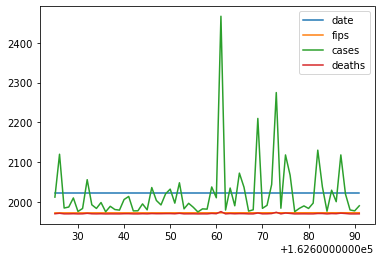

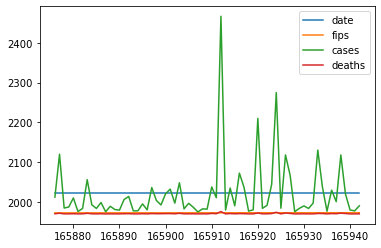

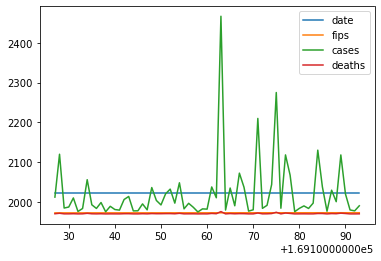

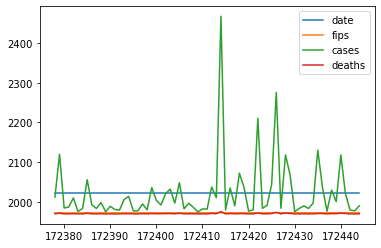

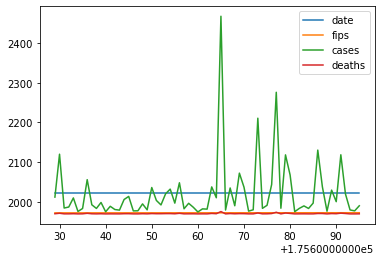

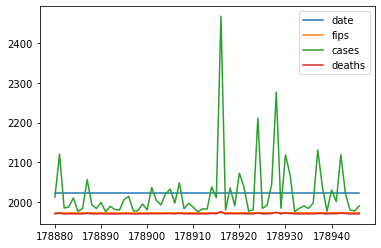

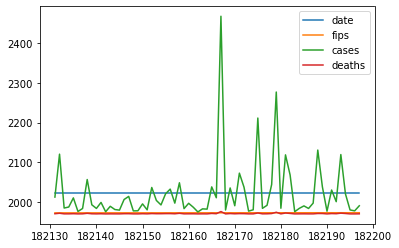

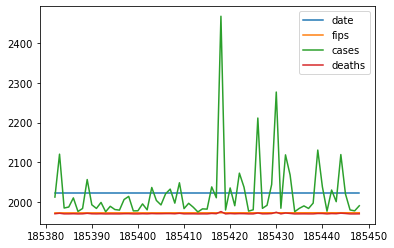

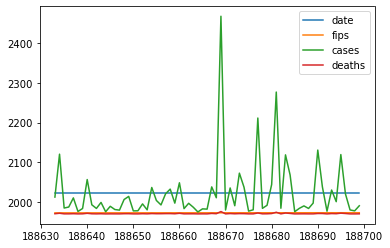

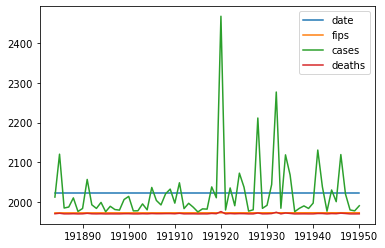

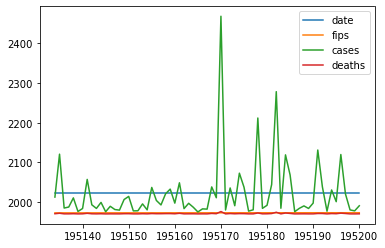

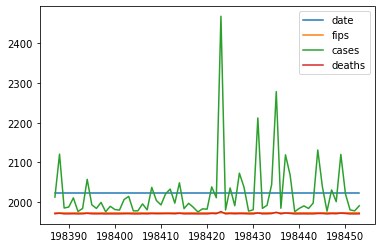

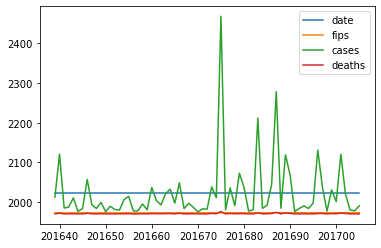

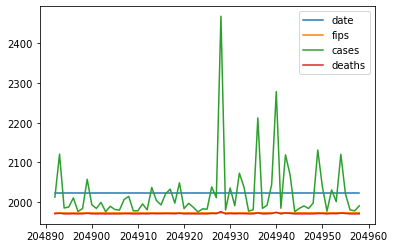

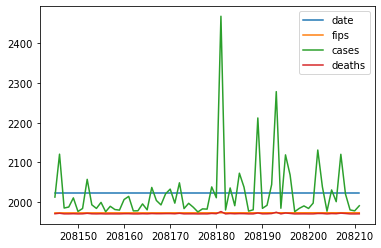

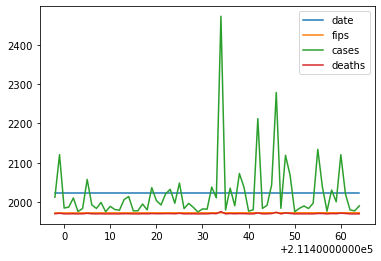

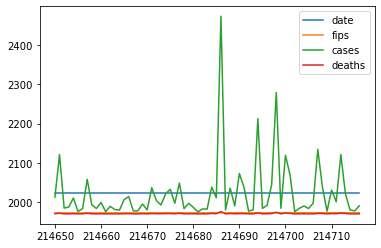

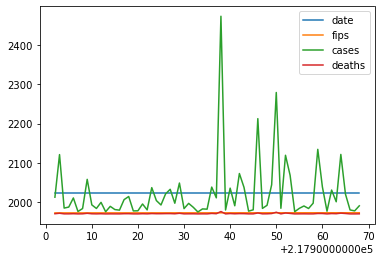

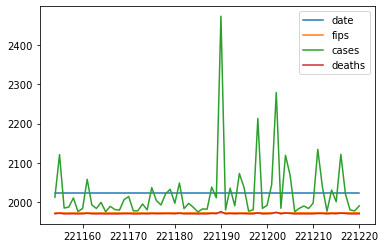

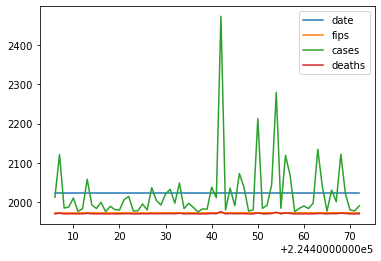

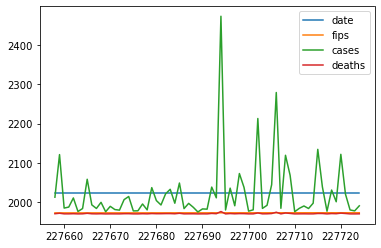

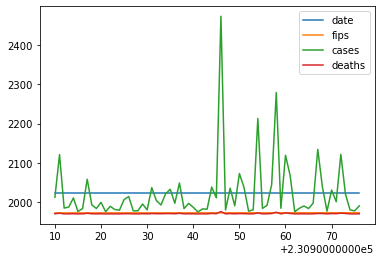

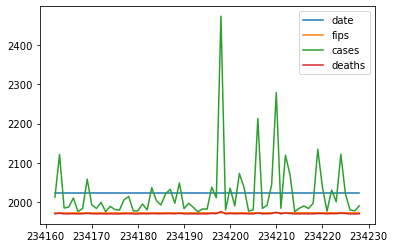

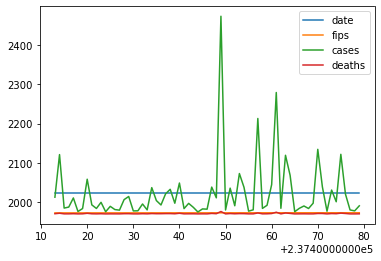

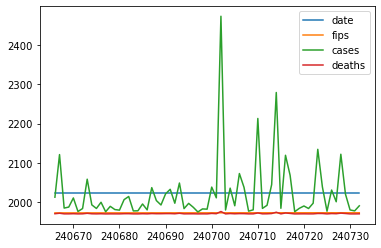

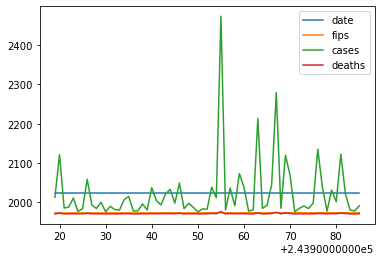

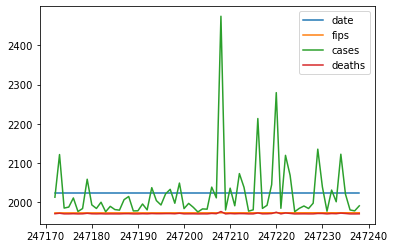

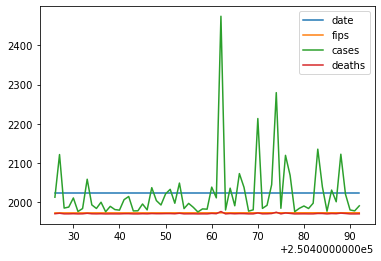

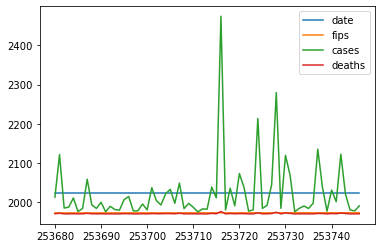

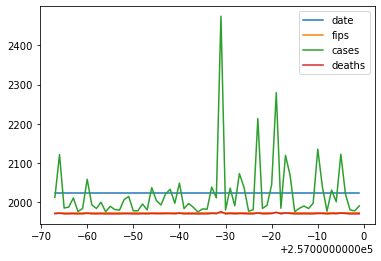

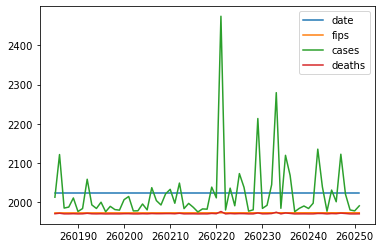

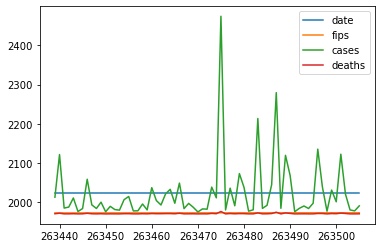

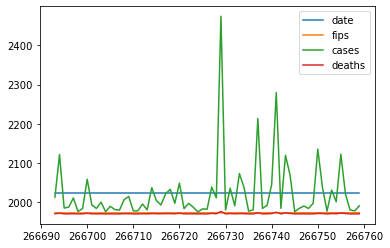

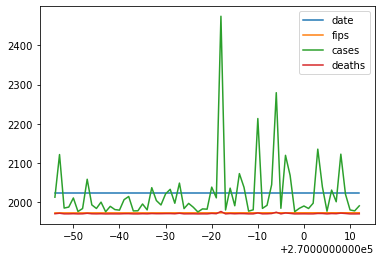

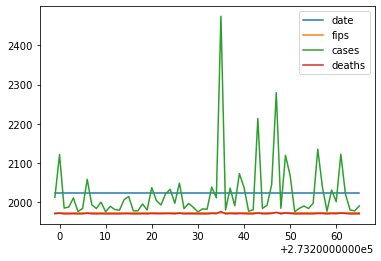

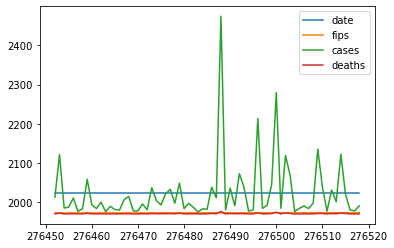

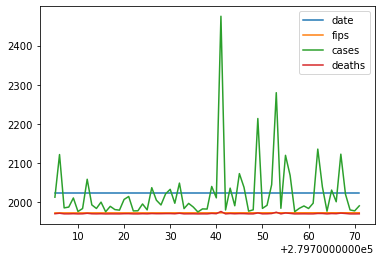

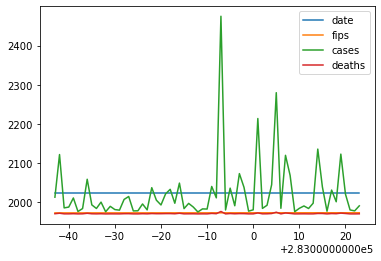

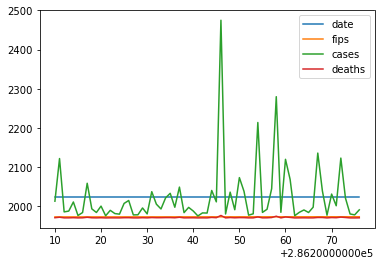

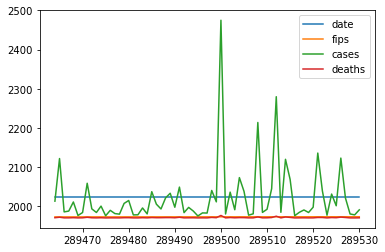

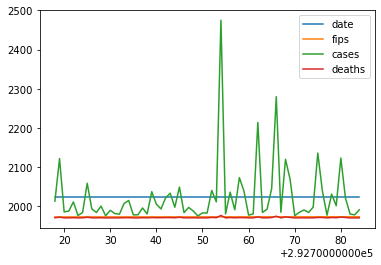

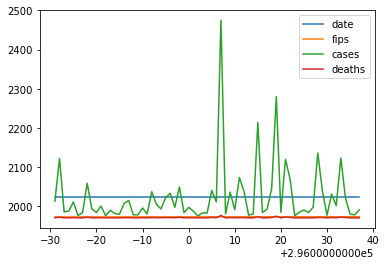

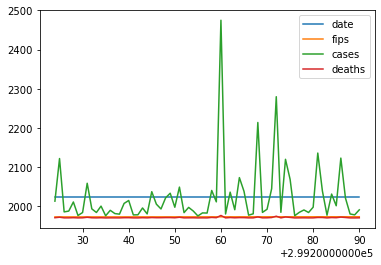

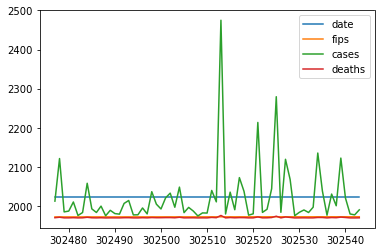

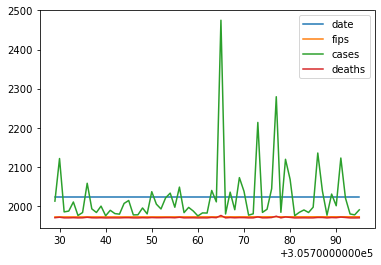

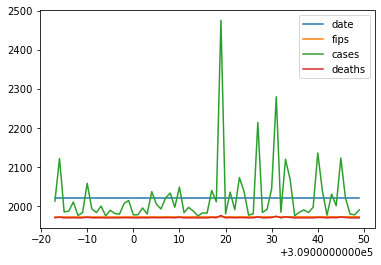

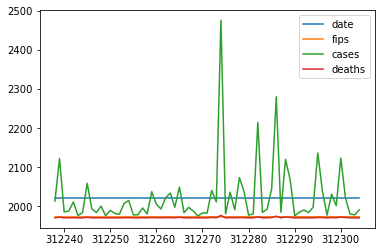

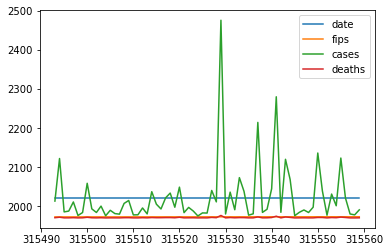

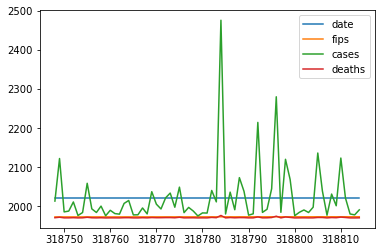

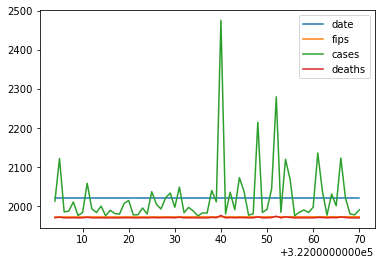

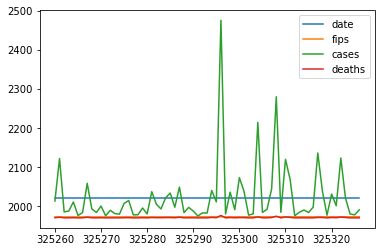

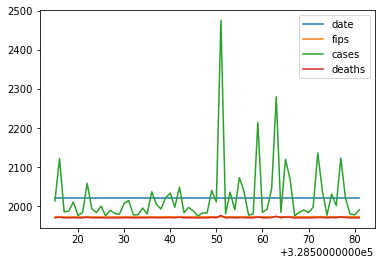

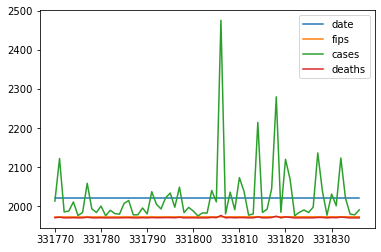

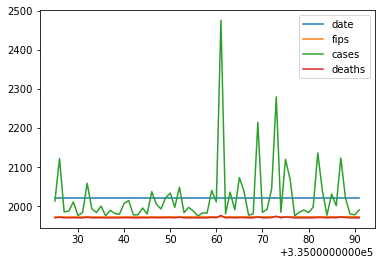

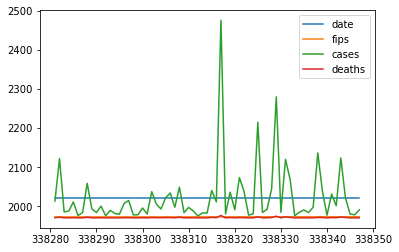

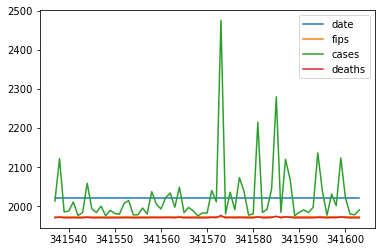

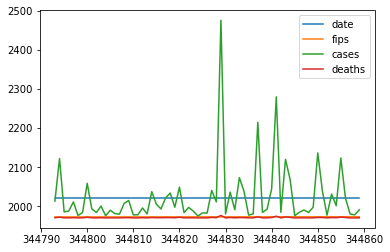

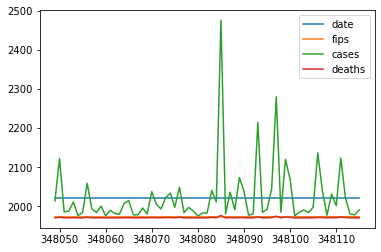

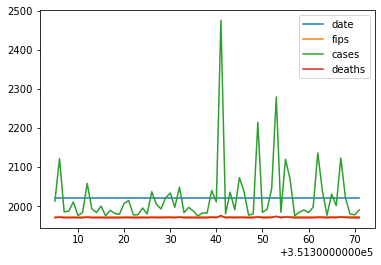

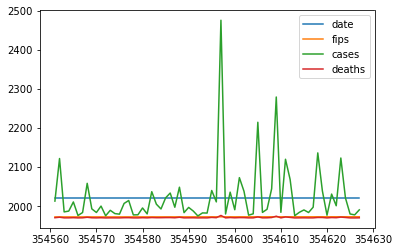

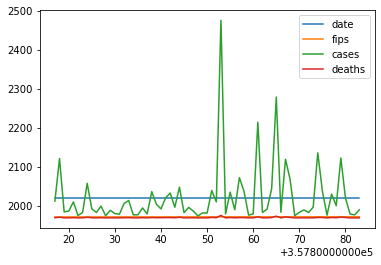

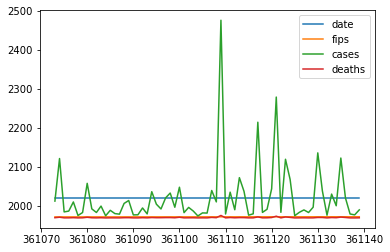

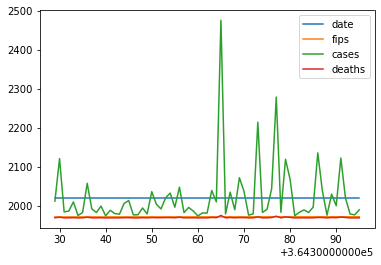

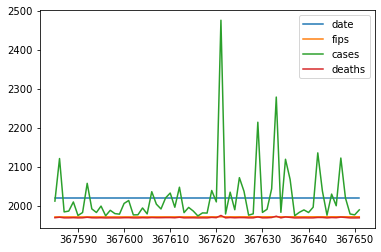

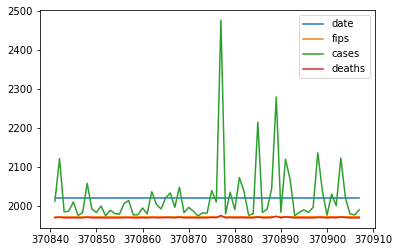

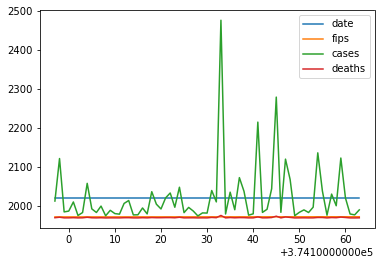

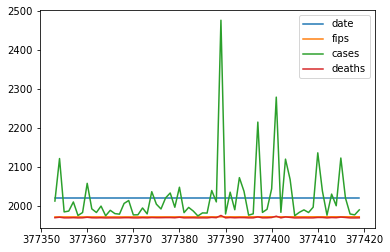

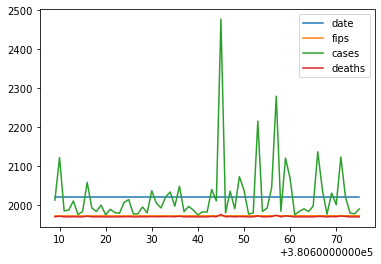

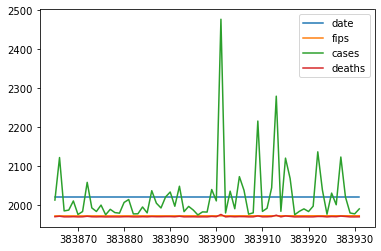

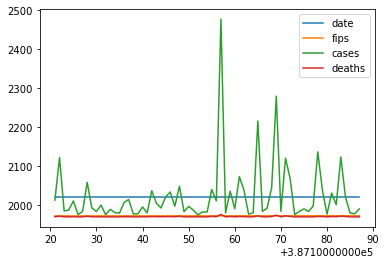

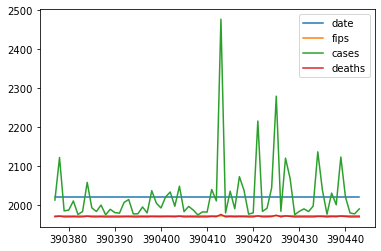

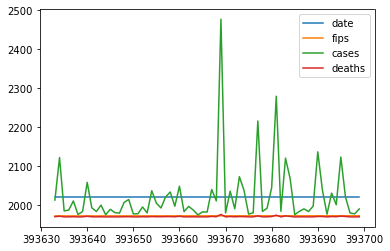

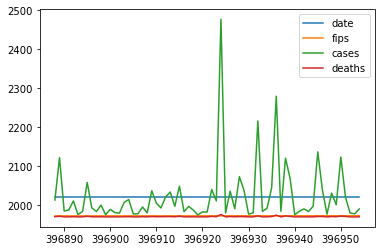

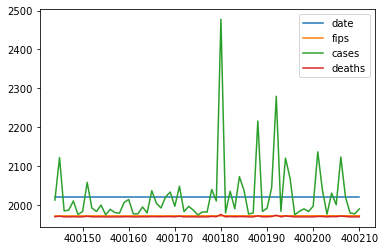

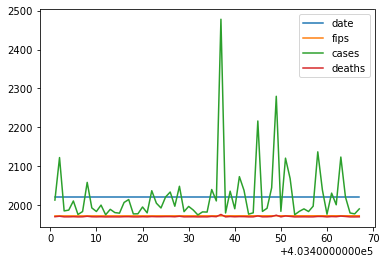

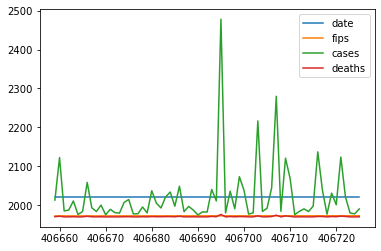

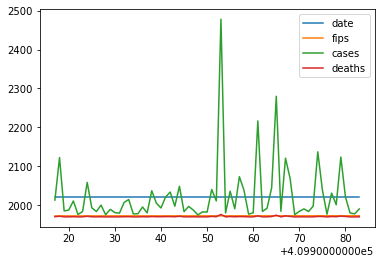

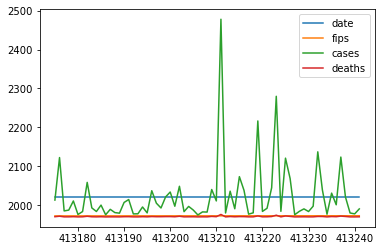

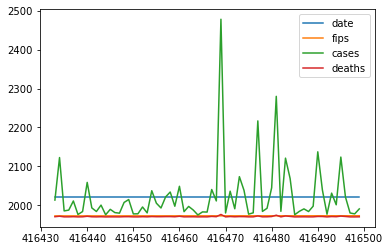

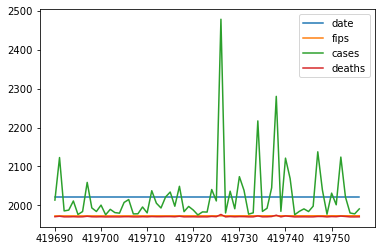

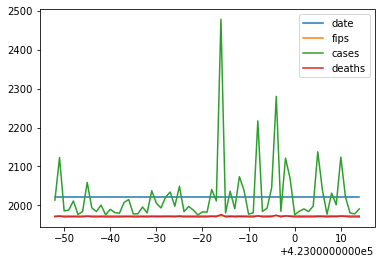

In [39]:
df[df['state']=='Alabama'].groupby('date').plot()

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train ,y_test = train_test_split(X, Y, test_size=0.2) # 切分数据集,分成训练集和验证集
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((329164,), (329164,), (82291,), (82291,))

In [13]:
len(x_train)

329164

In [29]:
y_train

255863          Oklahoma
298187          Oklahoma
234422          Colorado
85077            Georgia
259094          Oklahoma
               ...      
170122            Kansas
340445          Oklahoma
242617    North Carolina
264319              Iowa
18385               Ohio
Name: state, Length: 329164, dtype: object

In [21]:
x_train

255863      520
298187    11990
234422     5946
85077      1945
259094     8219
          ...  
170122     1618
340445    13572
242617    12864
264319     7980
18385     13917
Name: cases, Length: 329164, dtype: int64

In [40]:
x_train

255863      520
298187    11990
234422     5946
85077      1945
259094     8219
          ...  
170122     1618
340445    13572
242617    12864
264319     7980
18385     13917
Name: cases, Length: 329164, dtype: int64

In [11]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(x_train, y_train)
score = lg.score(x_test, y_test)

ValueError: Expected 2D array, got 1D array instead:
array=[  520. 11990.  5946. ... 12864.  7980. 13917.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.